# Laboratorio no calificado: Ingeniería de características con datos meteorológicos

En este primer ejercicio sobre ingeniería de características con datos de series temporales, practicará la transformación de datos con el [Conjunto de datos meteorológicos](https://www.bgc-jena.mpg.de/wetter/) registrado por el [Instituto Max Planck de Biogeoquímica](https://www.bgc-jena.mpg.de/). Aquí utilizará [tf.Transform](https://www.tensorflow.org/tfx/transform/get_started) en lugar de TFX porque, a partir de esta versión (1.4), es más sencillo conservar la secuencia de los registros utilizando este marco. Si recuerda, TFX por defecto siempre baraja los datos cuando los ingiere a través del componente `ExampleGen` y eso no es lo ideal cuando se preparan datos para aplicaciones de previsión.

Este conjunto de datos tiene intervalos de 10 minutos de 14 características diferentes como la temperatura del aire, la presión atmosférica y la humedad. Para este laboratorio, sólo se utilizarán los datos recogidos entre 2009 y 2016. Esta sección del conjunto de datos fue preparada por François Chollet para su libro *Deep Learning with Python*.

La siguiente tabla muestra los nombres de las columnas, sus formatos de valores y su descripción.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

Realizarás un preprocesamiento de datos para que las características puedan ser utilizadas para entrenar un LSTM usando TensorFlow y Keras. No se le pedirá que entrene un modelo, ya que el enfoque es el preprocesamiento de características.

Al finalizar, usted habrá

* Explorado y visualizado el conjunto de datos de las series temporales del tiempo y declarado su esquema
* Transformado los datos para el modelado utilizando [tf.Transform](https://www.tensorflow.org/tfx/transform/get_started)
* Preparado las ventanas del conjunto de datos de entrenamiento a partir de la salida de `tf.Transform`.

## Instalar los paquetes

En primer lugar, se instalarán los paquetes necesarios para este laboratorio. La mayoría están incluidos en el paquete `tensorflow_transform`.

In [1]:
!pip install tensorflow_transform==1.4.0
!pip install apache-beam==2.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 413 kB 5.5 MB/s 
     |████████████████████████████████| 570.3 MB 261 bytes/s 
     |████████████████████████████████| 129 kB 42.1 MB/s 
     |████████████████████████████████| 14.8 MB 721 kB/s 
     |████████████████████████████████| 19.1 MB 62.0 MB/s 
     |████████████████████████████████| 11.0 MB 3.0 MB/s 
     |████████████████████████████████| 23.6 MB 7.7 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 272 kB 57.4 MB/s 
     |████████████████████████████████| 2.4 MB 42.1 MB/s 
     |████████████████████████████████| 151 kB 53.0 MB/s 
     |████████████████████████████████| 2.5 MB 21.9 MB/s 
     |████████████████████████████████| 506 kB 49.7 MB/s 
     |████████████████████████████████| 148 kB 39.7 MB/s 
     |█████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 4.9 MB/s 
  Attempting uninstall: apache-beam
    Found existing installation: apache-beam 2.42.0
    Uninstalling apache-beam-2.42.0:
      Successfully uninstalled apache-beam-2.42.0


*Nota: En Google Colab, es necesario reiniciar el tiempo de ejecución en este punto para finalizar la actualización de los paquetes que acaba de instalar. Puede hacerlo haciendo clic en el botón "Reiniciar el tiempo de ejecución" al final de la celda de salida anterior (después de la instalación), o seleccionando "Tiempo de ejecución > Reiniciar el tiempo de ejecución" en la barra de menús. **Por favor, no pases a la siguiente sección sin reiniciar.** También puedes ignorar los errores de incompatibilidad de versiones de algunos de los paquetes incluidos porque no los usaremos en este cuaderno.*

## Imports

La ejecución de las importaciones que se indican a continuación no debería mostrar ningún error. De lo contrario, reinicie su tiempo de ejecución o vuelva a ejecutar la celda de instalación del paquete anterior.

In [1]:
import apache_beam as beam
print('Apache Beam version: {}'.format(beam.__version__))

import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

import tensorflow_transform as tft
from tensorflow_transform import beam as tft_beam
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import schema_utils
print('TensorFlow Transform version: {}'.format(tft.__version__))

Apache Beam version: 2.39.0
Tensorflow version: 2.6.5
TensorFlow Transform version: 1.4.0


## Download the Data

A continuación, descargará los datos y los colocará en su espacio de trabajo.

In [2]:
import os

# Directory of the raw data files
DATA_DIR = '/content/data/'

# Download the dataset
!wget -nc https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv -P {DATA_DIR}

# Assign data path to a variable for easy reference
INPUT_FILE = os.path.join(DATA_DIR, 'jena_climate_2009_2016.csv')

--2022-11-17 20:01:34--  https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43164220 (41M) [text/plain]
Saving to: ‘/content/data/jena_climate_2009_2016.csv’

jena_climate_2009_2 100%[===================>]  41.16M   168MB/s    in 0.2s    

2022-11-17 20:01:35 (168 MB/s) - ‘/content/data/jena_climate_2009_2016.csv’ saved [43164220/43164220]



**You** can now preview the dataset.

In [4]:
import pandas as pd

# Put dataset in a dataframe
df = pd.read_csv(INPUT_FILE, header=0, index_col=0)

# Preview the last few rows
df.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


Como puede ver arriba, se registra una observación cada 10 minutos. Esto significa que, para una sola hora, tendrá 6 observaciones. Del mismo modo, un solo día contendrá 144 (6x24) observaciones.

##Inspect the Data

A continuación, puede inspeccionar los datos para ver si hay algún problema que deba resolver antes de alimentar su modelo. En primer lugar, generará algunas estadísticas descriptivas utilizando el método [`describe()`](https://www.geeksforgeeks.org/python-pandas-dataframe-describe-method/) del marco de datos.



In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


Puedes ver que el valor mínimo para `wv (m/s)` y `max. wv(m/s)` es `-9999.0`. Esos son vientos bastante intensos y, basándose en los otros puntos de datos, parecen mediciones defectuosas. Esto es más pronunciado cuando visualizas los datos usando las utilidades de abajo.

In [6]:
# Define feature keys

TIMESTAMP_FEATURES = ["Date Time"]
NUMERIC_FEATURES = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)", 
    "rh (%)", 
    "VPmax (mbar)", 
    "VPact (mbar)", 
    "VPdef (mbar)", 
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

In [7]:
#@ title Visualization Utilities
import matplotlib.pyplot as plt

# Color Palette
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

# Plots each column as a time series
def visualize_plots(dataset, columns):
    features = dataset[columns]
    fig, axes = plt.subplots(
        nrows=len(columns)//2 + len(columns)%2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i, col in enumerate(columns):
        c = colors[i % (len(colors))]
        t_data = dataset[col]
        t_data.index = dataset.index
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(col),
            rot=25,
        )
    ax.legend([col])
    plt.tight_layout()

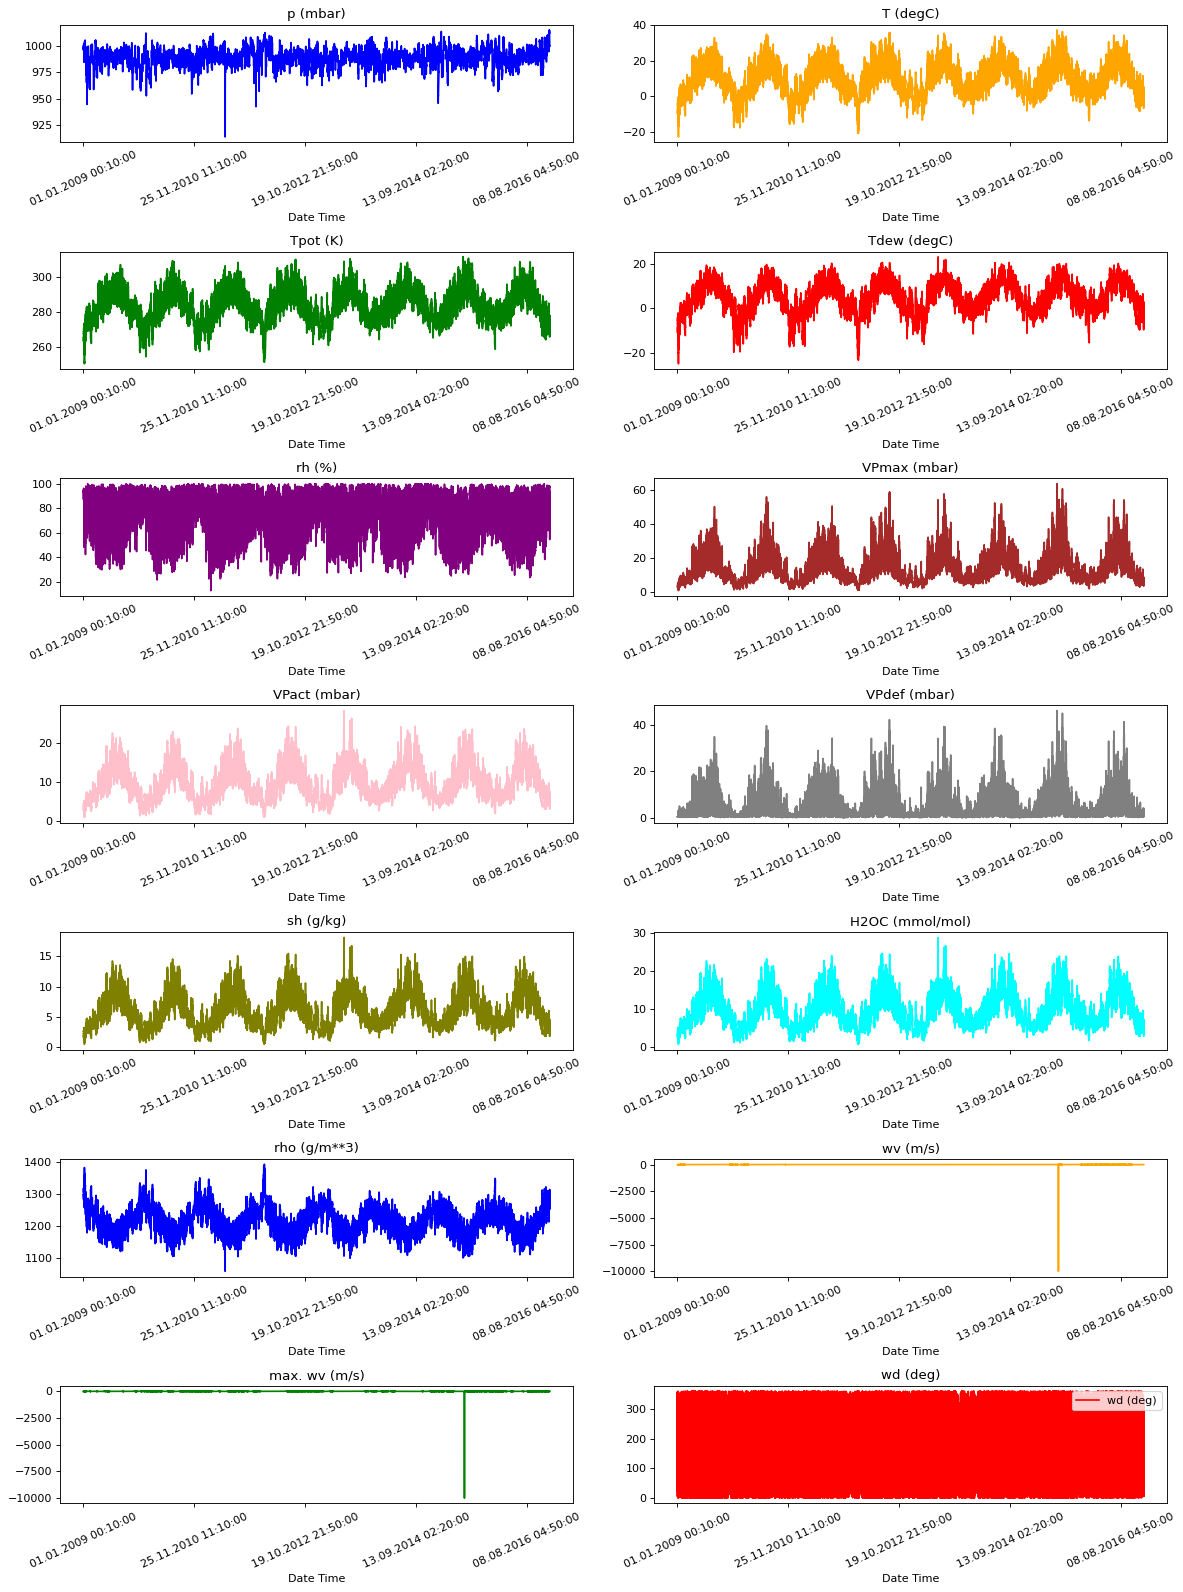

In [8]:
# Visualize the dataset
visualize_plots(df, NUMERIC_FEATURES)

Como puede ver, hay un pico descendente muy grande hacia `-9999` para las dos características mencionadas. Es posible que conozca diferentes métodos para manejar los valores atípicos, pero para simplificar este ejercicio, simplemente los establecerá en `0`. Puede visualizar los gráficos de nuevo después de hacer este cambio.

In [9]:
# Set the wind velocity outliers to 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

# Set the max wind velocity outliers to 0
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

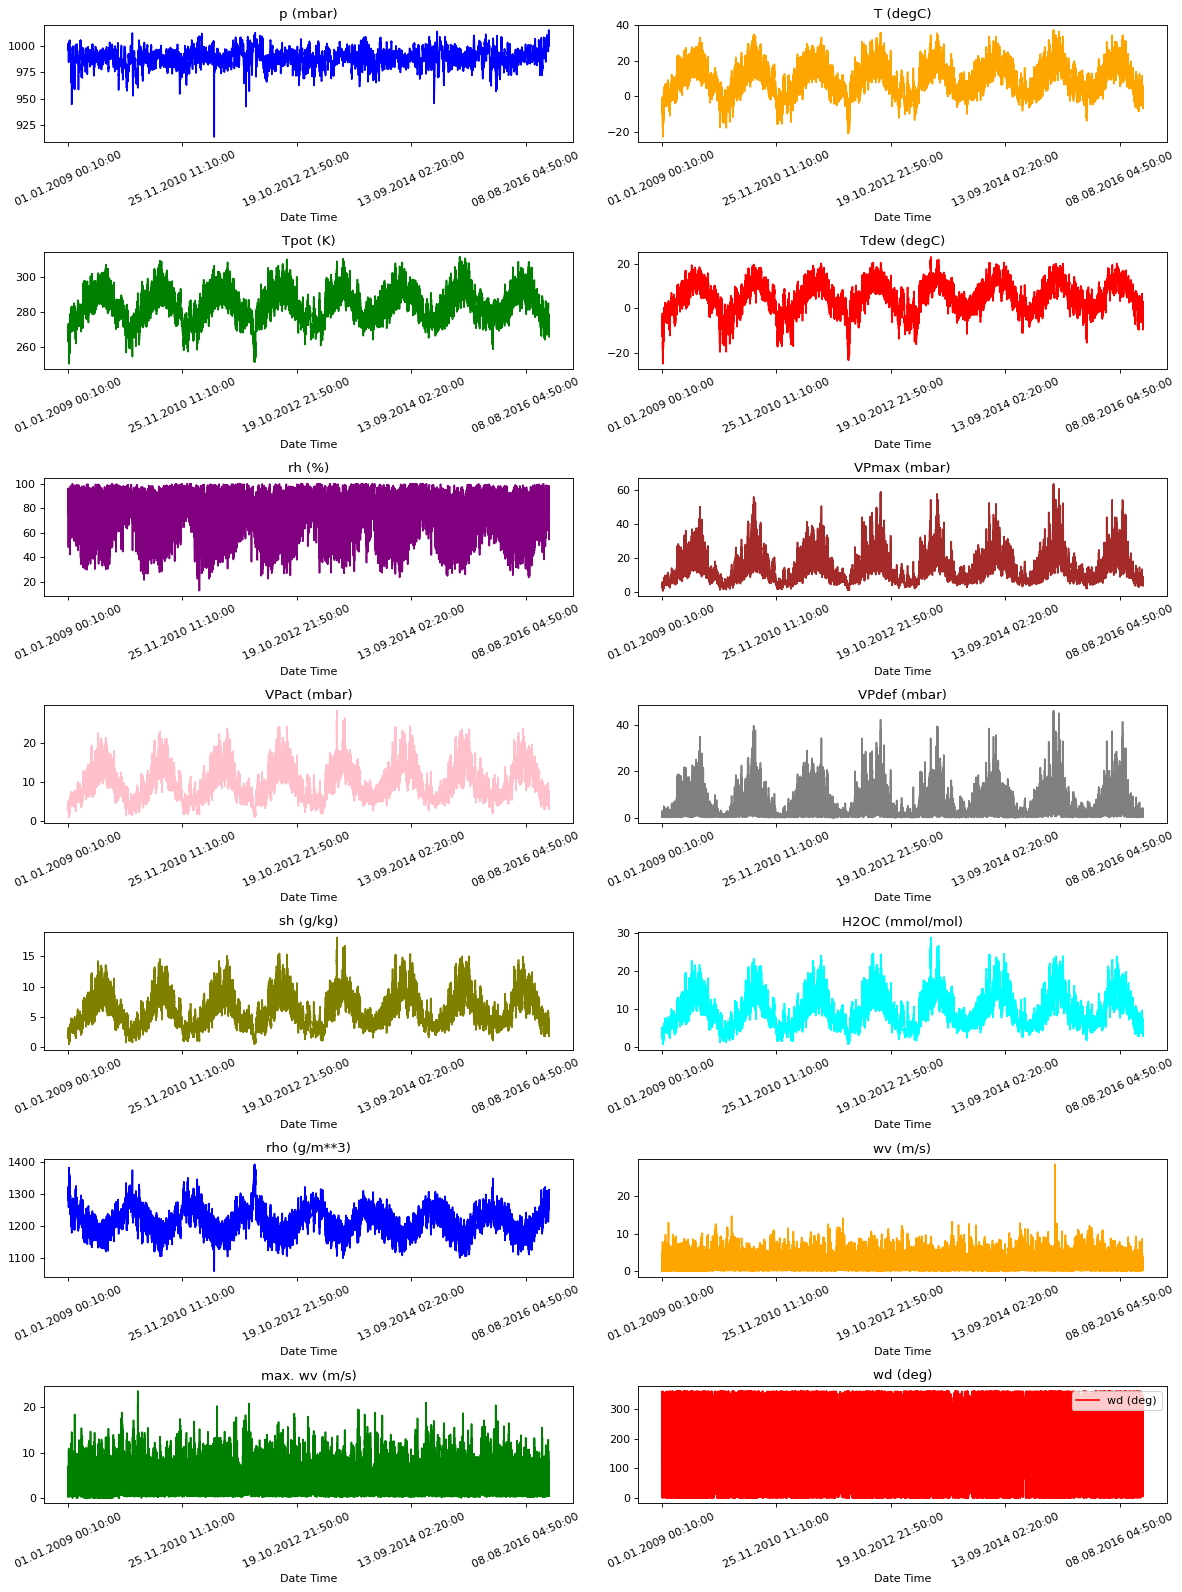

In [10]:
visualize_plots(df, NUMERIC_FEATURES)

Tenga en cuenta que sólo está visualizando el marco de datos de Pandas aquí. Usted hará esta simple limpieza de datos de nuevo más tarde cuando Tensorflow Transform consuma el archivo CSV en bruto.

## Feature Engineering

Ahora se hará la ingeniería de características. Hay varias cosas que hay que tener en cuenta antes de hacer la transformación:



### Correlated features

Es posible que desee eliminar las características redundantes para reducir la complejidad de su modelo. Veamos qué características están altamente correlacionadas entre sí trazando la matriz de correlación.

In [11]:
import seaborn as sns

def show_correlation_heatmap(dataframe):
    plt.figure(figsize=(20,20))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
    plt.show()

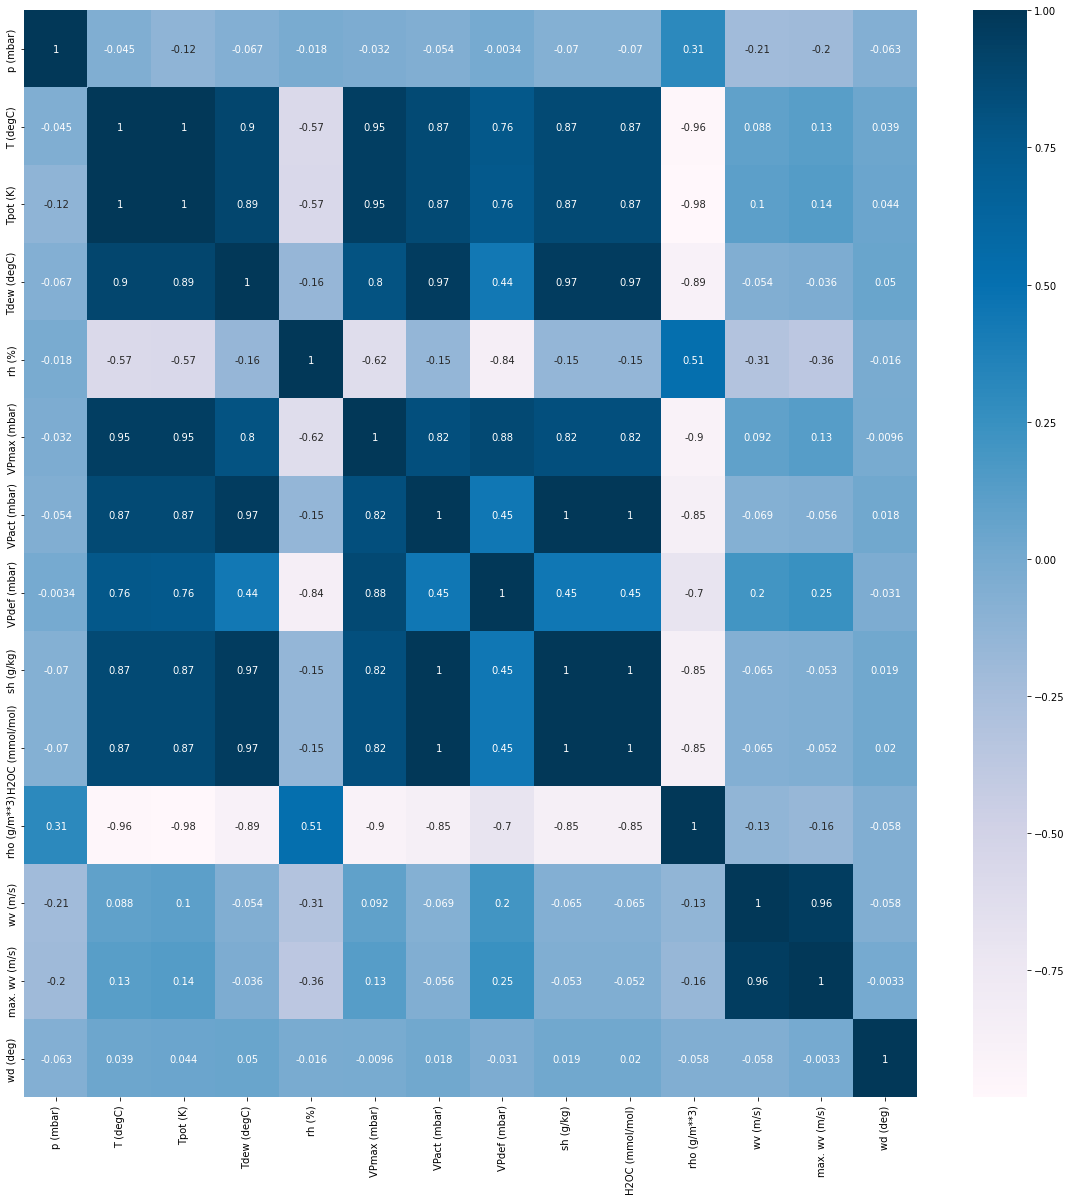

In [12]:
show_correlation_heatmap(df)

Puedes observar que `Tpot (K)`, `Tdew (degC)`, `VPmax(mbar)`, `Vpact(mbar)`, `VPdef (mbar)`, `sh(g/kg)` y `H2OC` están altamente correlacionados positivamente con el objetivo `T (degC)`. Asimismo, "rho" tiene una correlación muy negativa con el objetivo. 

En las características que están correlacionadas positivamente, se puede ver que `VPmax (mbar)` está altamente correlacionado con algunas características como `Vpact (mbar)`, `Tdew (degC)` y `Tpot (K)`. Por lo tanto, para este ejercicio se pueden eliminar estas características y mantener "VPmax (mbar)"..

In [13]:
# Features to filter out
FEATURES_TO_REMOVE = ["Tpot (K)", "Tdew (degC)","VPact (mbar)" , "H2OC (mmol/mol)", "max. wv (m/s)"]

### Distribution of Wind Data

La última columna de los datos, `wd (deg)`, da la dirección del viento en unidades de grados. Sin embargo, los ángulos en este formato actual no son una buena entrada para el modelo. Los 360° y los 0° deberían estar cerca el uno del otro y envolverse suavemente. La dirección no debería importar si el viento no sopla. Esto será más fácil de interpretar para el modelo si convierte las columnas de dirección y velocidad del viento en un vector de viento. Observe cómo el seno y el coseno se utilizan para generar las características del vector de viento (`Wx` y `Wy`) en el `preprocessing_fn()` más tarde.




### Date Time Feature

En lo que respecta al clima, se pueden esperar patrones según el momento en que se realicen las mediciones. Por ejemplo, las temperaturas suelen ser más frías por la noche y la velocidad del viento puede ser mayor durante la temporada de tifones. Por lo tanto, la columna "Fecha-Hora" es una buena entrada para que su modelo tenga en cuenta la periodicidad diaria y anual. 

Para ello, primero se utilizará el módulo de Python [datetime](https://docs.python.org/3/library/datetime.htm) para convertir el formato de cadena de fecha y hora actual (es decir, _día.mes.año hora:minuto:segundo_) en una marca de tiempo con unidades en segundos. A continuación, un enfoque sencillo para generar una señal periódica es utilizar de nuevo el seno y el coseno para convertir la marca de tiempo en señales claras de "Hora del día" (`Day sin`, `Day cos`) y "Hora del año" (`Year sin`, `Year cos`). Verás estas conversiones en las funciones `clean_fn()` y `preprocessing_fn()`. 

Puede ver la función de utilidad `clean_fn()` a continuación que elimina los valores atípicos de la velocidad del viento y convierte la cadena de fecha y hora a un [sello de tiempo Unix](https://www.unixtimestamp.com/).

In [14]:
from datetime import datetime

# combine features into one list
ordered_columns = TIMESTAMP_FEATURES + NUMERIC_FEATURES

# index of the date time string
date_time_idx = ordered_columns.index(TIMESTAMP_FEATURES[0])

# index of the 'wv (m/s)' feature
wv_idx = ordered_columns.index('wv (m/s)')

def clean_fn(line):
  '''
  Convierte las cadenas de fechas en el CSV a marcas de tiempo Unix y elimina los valores atípicos
  de la columna de velocidad del viento. Se utiliza como parte de
  del proceso de transformación.

  Args:
    line (string) - una fila de un archivo CSV
  
  Devuelve:

  '''

  # Split the CSV string to a list
  line_split = line.split(b',')

  # Decodes the timestamp string to utf-8
  date_time_string = line_split[date_time_idx].decode("utf-8")

  # Creates a datetime object from the timestamp string
  date_time = datetime.strptime(date_time_string, '%d.%m.%Y %H:%M:%S')

  # Generates a timestamp from the object
  timestamp = datetime.timestamp(date_time)

  # Overwrites the string timestamp in the row with the timestamp in seconds
  line_split[date_time_idx] = bytes(str(timestamp), 'utf-8')

  # Check if wind velocity is an outlier
  if line_split[wv_idx] == b'-9999.0':

    # Overwrite with default value of 0
    line_split[wv_idx] = b'0.0'

  # rejoin the list item into one string
  mod_line = b','.join(line_split)

  return mod_line

### Create a `tf.Transform` preprocessing_fn

Con las consideraciones anteriores, ahora puedes declarar tu `preprocessing_fn()`. Esto será utilizado por Tensorflow Transform para crear un gráfico de transformación que preprocesará las entradas del modelo. En pocas palabras, su función de preprocesamiento realizará los siguientes pasos:

1. Realizar la selección de características eliminando las características no deseadas. 
2. Transformar las columnas de dirección y velocidad del viento en un vector de viento.
3. Convertir la fecha en la marca de tiempo en una señal utilizable utilizando `sin` y `cos` para convertir la hora en señales claras de "Hora del día" y "Hora del año". 
4. 4. Normalizar las características flotantes.


In [15]:
import numpy as np
import math as m

def preprocessing_fn(inputs):
  """Preprocess input columns into transformed columns."""
  
  outputs = inputs.copy()

  # Filter redundant features
  for key in FEATURES_TO_REMOVE:
    del outputs[key]

  # Convert degrees to radians
  pi = tf.constant(m.pi)
  wd_rad = inputs['wd (deg)'] * pi / 180.0

  # Calculate the wind x and y components.
  outputs['Wx'] = inputs['wv (m/s)'] * tf.math.cos(wd_rad)
  outputs['Wy'] = inputs['wv (m/s)'] * tf.math.sin(wd_rad)

  # Delete `wv (m/s)` and `wd (deg)` after getting the wind vector
  del outputs['wv (m/s)']
  del outputs['wd (deg)']

  # Get day and year in seconds
  day = tf.cast(24*60*60, tf.float32)
  year = tf.cast((365.2425)*day, tf.float32)

  # Get timestamp feature
  timestamp_s = outputs['Date Time']

  # Convert timestamps into periodic signals
  outputs['Day sin']  = tf.math.sin(timestamp_s * (2 * pi / day))
  outputs['Day cos']  = tf.math.cos(timestamp_s * (2 * pi / day))
  outputs['Year sin'] = tf.math.sin(timestamp_s * (2 * pi / year))
  outputs['Year cos'] = tf.math.cos(timestamp_s * (2 * pi / year))

  # Delete timestamp feature
  del outputs['Date Time']

  # Declare final list of features
  FINAL_FEATURE_LIST =  ["p (mbar)",
    "T (degC)",
    "rh (%)", 
    "VPmax (mbar)", 
    "VPdef (mbar)", 
    "sh (g/kg)",
    "rho (g/m**3)",
    "Wx",
    "Wy",
    "Day sin",
    'Day cos',
    'Year sin',
    'Year cos'
    ]

  # Scale all features
  for key in FINAL_FEATURE_LIST:
    outputs[key] = tft.scale_to_0_1(outputs[key])

  return outputs

## Transform the data

Ya estás casi listo para empezar a transformar los datos en un pipeline de Apache Beam. Antes de hacerlo, declararás unas cuantas funciones y variables de utilidad más.

### Train Test Split

En primer lugar, definirá cómo se dividirá el conjunto de datos. Utilizará las primeras 300.000 observaciones para el entrenamiento y el resto para las pruebas.

Extraerá el objeto fecha-hora de la 300.000ª observación para utilizarlo en la partición del conjunto de datos utilizando [`Beam.Partition()`](https://beam.apache.org/documentation/transforms/python/elementwise/partition/). Este método espera un `partition_fn()` que devuelve un entero que indica el número de partición. Como sólo necesitarás dos (es decir, tren y prueba), harás que la función devuelva `0` cuando sea parte de la partición de tren, y `1` para la de prueba. Vea cómo se implementa esto en la celda de abajo.

In [16]:
# Number of records to include in the train split
TRAIN_SPLIT = 300000

# Get date time of the last element in the train split
date_time_train_boundary = df.iloc[TRAIN_SPLIT - 1].name

# Creates a datetime object from the timestamp string
date_time_train_boundary = datetime.strptime(date_time_train_boundary, '%d.%m.%Y %H:%M:%S')

# Convert date time string to Unix timestamp in seconds
date_time_train_boundary = bytes(str(datetime.timestamp(date_time_train_boundary)), 'utf-8')


def partition_fn(line, num_partitions):
  '''
  Función de partición para trabajar con Beam.partition

  Args:
    line (string) - Un registro en el archivo CSV.
    num_partition (integer) - Número de particiones. Argumento requerido por Beam. No se utiliza en esta función.

  Devuelve:
    0 o 1 (integer) - 0 si la marca de tiempo de la línea está por debajo del límite de tiempo de la fecha, 1 en caso contrario. 
  '''

  # Split the CSV string to a list
  line_split = line.split(b',')

  # Get the timestamp of the current line
  line_dt = line_split[date_time_idx]

  # Check if it is above or below the date time boundary
  partition_num = int(line_dt > date_time_train_boundary)

  return partition_num

### Declare Schema for Cleaned Data

Al igual que en los laboratorios anteriores con TFX, usted querrá declarar un esquema para asegurarse de que su entrada de datos se analiza correctamente. Puedes hacerlo con la celda de abajo. Tenga en cuenta que esto se utilizará más tarde después del paso de limpieza de datos. Por lo tanto, puede esperar que la característica de fecha y hora esté ahora en segundos y se asigne como una característica flotante.

In [17]:
# Declare feature spec
RAW_DATA_FEATURE_SPEC = dict(
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in TIMESTAMP_FEATURES] +
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in NUMERIC_FEATURES]
)

# Create schema from feature spec
RAW_DATA_SCHEMA = tft.tf_metadata.schema_utils.schema_from_feature_spec(RAW_DATA_FEATURE_SPEC)

### Create the `tf.Transform` pipeline

Ahora puede definir la tubería de TF Transform. Seguirá los siguientes pasos principales:

1. Leer los datos utilizando el lector CSV
1. 2. Eliminar los valores atípicos y reformatear las marcas de tiempo utilizando el `clean_fn`.
1. 2. Divida el conjunto de datos en dos partes, una de entrenamiento y otra de prueba, utilizando la transformación `beam.Partition`.
1. Preprocesar las divisiones de datos utilizando el `preprocessing_fn`.
1. Escribe el resultado como un `TFRecord` de protos `Example`.

In [18]:
import shutil
from tfx_bsl.coders.example_coder import RecordBatchToExamplesEncoder
from tfx_bsl.public import tfxio

# Directory names for the TF Transform outputs
WORKING_DIR = 'transform_dir'
TRANSFORM_TRAIN_FILENAME = 'transform_train'
TRANSFORM_TEST_FILENAME = 'transform_test'
TRANSFORM_TEMP_DIR = 'tft_temp'


# El bloque "con" creará una tubería, y ejecutará esa tubería a la salida
# del bloque.
def read_and_transform_data(working_dir):
  '''
  Rlee un archivo CSV y preprocesa los datos utilizando TF Transform

  Args:
    working_dir (string) - directorio para colocar las salidas de TF Transform
  
  Returns:
    transform_fn - transformation graph
    transformed_train_data - transformed training examples
    transformed_test_data - transformed test examples
    transformed_metadata - transform output metadata
  '''

  # Eliminar TF Transform si ya existe
  if os.path.exists(working_dir):
    shutil.rmtree(working_dir)

  with beam.Pipeline() as pipeline:
      with tft_beam.Context(temp_dir = os.path.join( working_dir, TRANSFORM_TEMP_DIR ) ):
        
        # Leer el CSV de entrada y limpiar los datos
        raw_data = (
              pipeline
              | 'ReadTrainData' >> beam.io.ReadFromText(INPUT_FILE, coder = beam.coders.BytesCoder(), skip_header_lines = 1)
              | 'CleanLines'    >> beam.Map(clean_fn))

        # Divida el conjunto de datos en conjuntos de entrenamiento y de prueba utilizando el partition_fn definido anteriormente.    
        raw_train_data, raw_test_data = (raw_data
                                                 | 'TrainTestSplit' >> beam.Partition(partition_fn, 2))
        
        # Crear un TFXIO para leer los datos con el esquema. Es necesario
        # listar todas las columnas en orden ya que el esquema no especifica el
        # orden de las columnas en el csv.
        csv_tfxio = tfxio.BeamRecordCsvTFXIO(
                                              physical_format = 'text',
                                              column_names    = ordered_columns,
                                              schema          = RAW_DATA_SCHEMA)

        # Analizar los datos brutos del tren en entradas para la Transformación TF
        raw_train_data = (raw_train_data 
                                        | 'DecodeTrainData' >> csv_tfxio.BeamSource() )
        
        # Obtener los metadatos de los datos brutos
        RAW_DATA_METADATA = csv_tfxio.TensorAdapterConfig()
        
        # Emparejar los datos del tren con los metadatos en una tupla
        raw_train_dataset = (raw_train_data, RAW_DATA_METADATA)

        # Transformación de los datos de entrenamiento. El formato de salida TFXIO (RecordBatch)
        # se elige para mejorar el rendimiento.
        (transformed_train_data , transformed_metadata) , transform_fn = (
                                raw_train_dataset | 
                                tft_beam.AnalyzeAndTransformDataset(
                                                              preprocessing_fn, 
                                                              output_record_batches = True)
                                )


        # Parsear los datos brutos en entradas para TF Transform
        raw_test_data = (raw_test_data
                         | 'DecodeTestData' >> csv_tfxio.BeamSource())
        
        # Emparejar los datos de la prueba con los metadatos en una tupla
        raw_test_dataset = (raw_test_data, RAW_DATA_METADATA)
        
        # Ahora aplique la misma función de transformación a los datos de prueba.
        # No necesitas el esquema de datos transformados. Es el mismo que antes.
        transformed_test_data, _ = (
          (raw_test_dataset, transform_fn) | tft_beam.TransformDataset(output_record_batches=True))
        
        # Declara un codificador para convertir los lotes de registros de salida en TF Ejemplos 
        transformed_data_coder = RecordBatchToExamplesEncoder(transformed_metadata.schema)
        
        # Codificar los datos del tren transformados y escribir en el disco
        _ = (
            transformed_train_data
            | 'EncodeTrainData' >> beam.FlatMapTuple(lambda batch, _: transformed_data_coder.encode(batch))
            | 'WriteTrainData' >> beam.io.WriteToTFRecord(
                os.path.join(working_dir, TRANSFORM_TRAIN_FILENAME)))

        # Codificar los datos de prueba transformados y escribir en el disco
        _ = (
            transformed_test_data
            | 'EncodeTestData' >> beam.FlatMapTuple(lambda batch, _: transformed_data_coder.encode(batch))
            | 'WriteTestData' >> beam.io.WriteToTFRecord(
                os.path.join(working_dir, TRANSFORM_TEST_FILENAME)))
        
        # Escribir la función de transformación en el disco
        _ = (
          transform_fn
          | 'WriteTransformFn' >>
          tft_beam.WriteTransformFn(os.path.join(working_dir)))

         
  return transform_fn, transformed_train_data, transformed_test_data, transformed_metadata

In [19]:
def main():
  return read_and_transform_data(WORKING_DIR)

if __name__ == '__main__':
  transform_fn, transformed_train_data, trainsformed_test_data, transformed_metadata = main()

Instructions for updating:
Use ref() instead.


##Prepare Training and Test Datasets from TFTransformOutput

Ahora que tiene el conjunto de datos transformado, tendrá que asignarlo a los conjuntos de datos de entrenamiento y de prueba que se pueden utilizar para entrenar un modelo utilizando TensorFlow. Dado que se trata de datos de series temporales, tiene sentido agrupar una serie de mediciones de longitud fija y asignarla a la etiqueta encontrada en un paso de tiempo futuro. Por ejemplo, 3 días de datos pueden ser utilizados para predecir la humedad del día siguiente. Puede utilizar el método [tf.data.Dataset.window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) para implementar estas agrupaciones.

En este ejercicio, utilizarás los datos de los últimos 5 días para predecir la temperatura 12 horas en el futuro. 

* Ya sabes que los datos se toman cada 10 minutos por lo que habrá 720 puntos de datos para 5 días. 
* También asumirá que no se espera un cambio drástico en una hora, por lo que reducirá la muestra de los 720 puntos de datos a 120, obteniendo los datos cada hora. Por lo tanto, utilizará una *fase* (o tamaño de paso) de 6 al obtener los puntos de datos. Esto hace que el `HISTORY_SIZE` para la ventana de características sea igual a 120. 
* Para este modelo de predicción de un solo paso (previsión), la etiqueta para una ventana del conjunto de datos será la temperatura de 12 horas en el futuro.
* Por defecto, el método `window()` mueve pasos de `tamaño` (es decir, tamaño de la ventana) a la vez. Por ejemplo, si tiene un conjunto de datos con elementos `[1, 2, 3, 4]` y tiene `size=2`, entonces sus resultados serán como: `[1, 2], [3, 4]`. Puede reconfigurar este comportamiento y moverse a pasos más pequeños o más grandes con el parámetro `shift`. Para el mismo conjunto de datos de muestra con ventana `tamaño=2` pero con `desplazamiento=1`, los resultados se verán como `[1, 2], [2,3], [3,4]` porque la ventana se está moviendo `1` elemento a la vez.

In [20]:
# Constants to prepare the transformed data for modeling

LABEL_KEY = 'T (degC)'
OBSERVATIONS_PER_HOUR = 6
HISTORY_SIZE = 120
FUTURE_TARGET = 12
BATCH_SIZE = 72
SHIFT = 1

In [21]:
# Get the output of the Transform component
tf_transform_output = tft.TFTransformOutput(os.path.join(WORKING_DIR))

# Get the index of the label key
index_of_label = list(tf_transform_output.transformed_feature_spec().keys()).index(LABEL_KEY)
print(index_of_label)

2


A continuación, definirá varias funciones de ayuda para extraer los datos de su conjunto de datos transformados y agruparlos en ventanas. En primer lugar, esta función `parse_function()` ayudará a obtener las características transformadas y a reordenarlas para que los valores de la etiqueta (es decir, `T (degC)`) estén al final del tensor.

In [23]:
def parse_function(example_proto):
    
    feature_spec = tf_transform_output.transformed_feature_spec()
    
    # Define features with the example_proto (transformed data) and the feature_spec using tf.io.parse_single_example 
    features = tf.io.parse_single_example(example_proto, feature_spec)
    values = list(features.values())
    values[index_of_label], values[len(features) - 1] = values[len(features) - 1], values[index_of_label]
    
    # Stack the values along the first axis
    stacked_features = tf.stack(values, axis=0)

    return stacked_features


A continuación, separará las características y los valores de destino en una tupla con esta función de utilidad.

In [24]:
def map_features_target(elements):
    features = elements[:HISTORY_SIZE]
    target = elements[-1:,-1]
    return (features, target)

Por último, puede definir la ventana del conjunto de datos con la función siguiente. Utiliza los parámetros definidos anteriormente y también las funciones de ayuda para producir los mapeos de característica-objetivo por lotes.

In [25]:
def get_windowed_dataset(path):
        
    # Instantiate a tf.data.TFRecordDataset passing in the appropiate path
    dataset = tf.data.TFRecordDataset(path)
    
    # Use the dataset's map method to map the parse_function
    dataset = dataset.map(parse_function)
    
    # Use the window method with expected total size. Define stride and set drop_remainder to True
    dataset = dataset.window(HISTORY_SIZE + FUTURE_TARGET, shift=SHIFT, stride=OBSERVATIONS_PER_HOUR, drop_remainder=True)
    
    # Use the flat_map method passing in an anonymous function that given a window returns window.batch(HISTORY_SIZE + FUTURE_TARGET)
    dataset = dataset.flat_map(lambda window: window.batch(HISTORY_SIZE + FUTURE_TARGET))
    
    # Use the map method passing in the previously defined map_features_target function
    dataset = dataset.map(map_features_target) 
    
    # Use the batch method and pass in the appropiate batch size
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

Ahora puede utilizar la función `get_dataset()` en sus ejemplos transformados para producir las ventanas del conjunto de datos.

In [26]:
# Get list of train and test data tfrecord filenames from the transform outputs
train_tfrecord_files = tf.io.gfile.glob(os.path.join(WORKING_DIR, TRANSFORM_TRAIN_FILENAME + '*'))
test_tfrecord_files = tf.io.gfile.glob(os.path.join(WORKING_DIR, TRANSFORM_TEST_FILENAME + '*'))

# Generate dataset windows
windowed_train_dataset = get_windowed_dataset(train_tfrecord_files[0])
windowed_test_dataset = get_windowed_dataset(test_tfrecord_files[0])

Veamos las formas resultantes de las ventanas de datos. Si imprime las formas de los tensores en un solo lote, notará que efectivamente produjo las dimensiones requeridas. Tiene 72 ejemplos por lote donde cada uno contiene 120 medidas para cada una de las 13 características del conjunto de datos transformado. La forma del tensor objetivo sólo tiene una característica por ejemplo en el lote como se esperaba (es decir, sólo `T (degC)`).

In [28]:
ordered_feature_spec_names = tf_transform_output.transformed_feature_spec().keys()

# Preview an example in the train dataset
for features, target  in windowed_train_dataset.take(1):
    print(f'Shape of input features for a batch: {features.shape}')
    print(f'Shape of targets for a batch: {target.shape}\n')

    print(f'INPUT FEATURES:')
    for value, name in zip(features[0][0].numpy(), ordered_feature_spec_names):
      print(f'{name} : {value}') 
  
    print(f'\nTARGET TEMPERATURE: {target[0][0]}')

Shape of input features for a batch: (72, 120, 13)
Shape of targets for a batch: (72, 1)

INPUT FEATURES:
Day cos : 0.9994063377380371
Day sin : 0.5243587493896484
T (degC) : 0.08167896419763565
VPdef (mbar) : 0.0052231717854738235
VPmax (mbar) : 0.04098501801490784
Wx : 0.5456575155258179
Wy : 0.5428817868232727
Year cos : 0.9999775886535645
Year sin : 0.5047342777252197
p (mbar) : 0.8355501890182495
rh (%) : 0.9230327606201172
rho (g/m**3) : 0.743212878704071
sh (g/kg) : 0.25462883710861206

TARGET TEMPERATURE: 0.14098861813545227


In [29]:
# Preview an example in the test dataset
for features, target in windowed_test_dataset.take(1):
    print(f'Shape of input features for a batch: {features.shape}')
    print(f'Shape of targets for a batch: {target.shape}\n')

    print(f'INPUT FEATURES:')
    for value, name in zip(features[0][0].numpy(), ordered_feature_spec_names):
      print(f'{name} : {value}') 
  
    print(f'\nTARGET TEMPERATURE: {target[0][0]}')

Shape of input features for a batch: (72, 120, 13)
Shape of targets for a batch: (72, 1)

INPUT FEATURES:
Day cos : 0.9083542823791504
Day sin : 0.7885253429412842
T (degC) : 0.5666477680206299
VPdef (mbar) : 0.004748338367789984
VPmax (mbar) : 0.27363526821136475
Wx : 0.69806307554245
Wy : 0.5810309648513794
Year cos : 0.3435264229774475
Year sin : 0.025114715099334717
p (mbar) : 0.8016924262046814
rh (%) : 0.9862148761749268
rho (g/m**3) : 0.4026159942150116
sh (g/kg) : 0.6419228911399841

TARGET TEMPERATURE: 0.7635467648506165


## Wrap Up

En este cuaderno, tiene que ver cómo puede querer preparar datos estacionales. Muestra cómo puede manejar la periodicidad y producir lotes de ventanas de conjuntos de datos. En el siguiente laboratorio harás algo similar con los datos de los sensores. Esta vez, sin embargo, las mediciones se toman a una velocidad mucho mayor (20 Hz). Las etiquetas también son categóricas, por lo que las manejarás de manera diferente.

¡A la siguiente!